In [1]:
from tensorflow.keras.models import load_model
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.vae_model import vae_model
from src.lstm_mapper_model import mapper_model
#from src.lstm_mapper_model import lstm_mapper_model
from src.util import (
    seq_data, 
    load_sim_data,  
    compute_perm_deviation, 
    calculate_perm_error, 
    select_random_instances,
    plot_boxplot,
    mesh_plot_comparisons,
    plot_mesh_permarray,
    load_exp_data,
    plot_mesh
)
from pyeit import mesh
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tqdm import tqdm
import pandas as pd
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2025-01-15 13:41:48.279036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736948508.301030 1327005 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736948508.309047 1327005 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 13:41:48.328936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1736948522.316796 1327005 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

## Load Data

In [2]:
n_el = 32
from pyeit import mesh
mesh_obj = mesh.create(n_el, h0=0.05)

In [3]:
def load_and_concatenate_data(folder_paths, seq_data_function, n_seg=4):
    all_voltage_seq = []
    all_gamma_seq = []
    
    for folder in tqdm(folder_paths, desc="Processing folders"):
        voltage_sim, gamma_sim, _ = load_sim_data(folder) 
        voltage = (voltage_sim - np.mean(voltage_sim, axis=0)) / np.std(voltage_sim, axis=0)
        voltage = voltage.reshape(-1, 32, 32, 1)
        gamma = gamma_sim.reshape(-1, 2840, 1)
        voltage_seq, gamma_seq = seq_data_function(voltage, gamma, n_seg=n_seg)
        
        all_voltage_seq.append(voltage_seq)
        all_gamma_seq.append(gamma_seq)
        
    concatenated_voltage_seq = np.concatenate(all_voltage_seq, axis=0)
    concatenated_gamma_seq = np.concatenate(all_gamma_seq, axis=0)
    return concatenated_voltage_seq, concatenated_gamma_seq

#folder_paths = ["data34", "data35", "data36", "data37", "data38", "data39"]
folder_paths = ["data44", "data45"]
voltage_seq, gamma_seq = load_and_concatenate_data(folder_paths, seq_data, n_seg=4)
print("Concatenated Voltages Shape:", voltage_seq.shape)
print("Concatenated Permittivity Shape:", gamma_seq.shape)

Processing folders: 100%|██████████| 2/2 [01:32<00:00, 46.30s/it]


Concatenated Voltages Shape: (23992, 4, 32, 32, 1)
Concatenated Permittivity Shape: (23992, 2840, 1)


## Loading VAE Model and generating labels

In [4]:
vae = vae_model()  
vae.build(input_shape=(None, 2840)) 
vae.load_weights("weights/vae2D_best_6000.weights.h5")
print("Gewichte erfolgreich geladen.")

_, _, latent_rep = vae.encoder.predict(gamma_seq)

Gewichte erfolgreich geladen.
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


## LSTM Mapper Training

In [5]:
(
    v_train_seq,
    v_test_seq,
    gamma_train,
    gamma_test,
    z_train,
    z_test,
) = train_test_split(
    voltage_seq,
    gamma_seq,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [6]:
lstm_mapper = mapper_model()
lstm_mapper.summary()
lstm_mapper.compile(optimizer="adam", loss="mse")

Model: "lstm_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 4, 32, 32, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 4, 15, 15, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 4, 7, 7, 2)     │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 4, 98)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 4, 64)          │         6,336 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,082 (86.26 KB)

 Trainable params: 22,082 (86.26 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Training mit EarlyStopping
history_mapper = lstm_mapper.fit(
    v_train_seq, 
    z_train, 
    epochs=100, 
    batch_size=8, 
    validation_split=0.1,
    callbacks=[stop_early]
)

Epoch 1/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.3809 - val_loss: 0.1389
Epoch 2/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1355 - val_loss: 0.1287
Epoch 3/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1244 - val_loss: 0.1261
Epoch 4/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1229 - val_loss: 0.1226
Epoch 5/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1192 - val_loss: 0.1205
Epoch 6/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1157 - val_loss: 0.1204
Epoch 7/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1165 - val_loss: 0.1209
Epoch 8/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1154 - val_loss: 0.1214
Epoch 9/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1124 - val_loss: 0.1211
Epoch 10/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1123 - val_loss: 0.1197
Epoch 11/100
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1114 - val_loss: 0.1213
Epoch 12/100
2429/

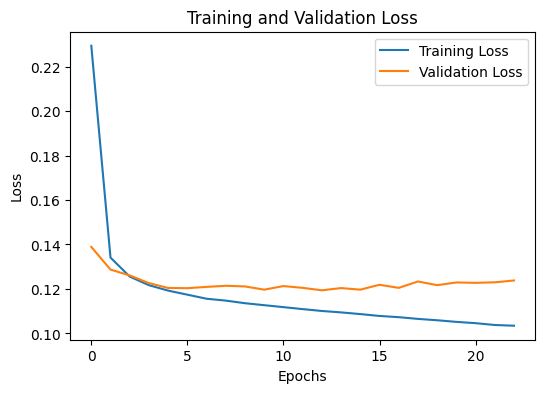

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(history_mapper.history["loss"], label="Training Loss")
plt.plot(history_mapper.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [15]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
lstm_weights_file = os.path.join(weights_dir, "lstm_circle_interpolation_025_075.weights.h5")
lstm_mapper.save_weights(lstm_weights_file)
print(f"Gewichte gespeichert unter: {lstm_weights_file}")

Gewichte gespeichert unter: weights/lstm_circle_interpolation_025_075.weights.h5


In [18]:
lstm_mapper.load_weights("weights/lstm_circle_interpolation_025_075.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [19]:
_, _, pred_latent = vae.encoder.predict(gamma_test)
gamma_pred = vae.decoder.predict(pred_latent).reshape(-1, 2840)

pred_latent.shape, v_test_seq.shape, gamma_pred.shape

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


((2400, 8), (2400, 4, 32, 32, 1), (2400, 2840))

In [20]:
def compute_deviation(mesh_obj, true_perm, predicted_perm, threshhold=0.5):
    pts = mesh_obj.element
    tri = mesh_obj.node

    tri_centers = np.mean(tri[pts], axis=1)

    ixds_true = np.array(np.where(true_perm > threshhold)[0])
    koords_true = tri_centers[ixds_true]
    x_true = np.round(np.mean(koords_true[:, 0]), 2)
    y_true = np.round(np.mean(koords_true[:, 1]), 2)

    ixds_pred = np.array(np.where(predicted_perm > threshhold)[0])
    koords_pred = tri_centers[ixds_pred]
    x_pred = np.round(np.mean(koords_pred[:, 0]), 2)
    y_pred = np.round(np.mean(koords_pred[:, 1]), 2)

    deviation = (x_pred - x_true, y_pred - y_true)

    return deviation, (x_true, y_true), (x_pred, y_pred), koords_true, koords_pred


def plot_random_deviations(mesh_obj, true_perms, predicted_perms, num_samples=10, threshhold=0.5, 
                      save=False, fpath='Abbildungen/', fname='random_deviations.pdf'):
   
    random_indices = np.random.choice(len(true_perms), size=num_samples, replace=False)
    cols = 5
    rows = int(np.ceil(num_samples / cols))
    
    subplot_size = 4 
    fig, axes = plt.subplots(rows, cols, figsize=(cols * subplot_size, rows * subplot_size))
    axes = axes.flatten()
    
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        true_perm = true_perms[idx]
        predicted_perm = predicted_perms[idx]
        deviation, (x_true, y_true), (x_pred, y_pred), koords_true, koords_pred = compute_deviation(
            mesh_obj, true_perm, predicted_perm, threshhold=threshhold
        )
        
        ax.grid()
        ax.set_xlim((-1, 1))
        ax.set_ylim((-1, 1))
        ax.set_aspect('equal')
        
        ax.scatter(mesh_obj.node[:, 0], mesh_obj.node[:, 1], color="grey", s=0.1, label="Mesh")
        ax.scatter(koords_true[:, 0], koords_true[:, 1], color="C1", s=2, label="True")
        ax.scatter(koords_pred[:, 0], koords_pred[:, 1], color="C2", s=2, label="Pred")
        ax.scatter(x_true, y_true, marker="x", color="C3", s=50, label="Center True")
        ax.scatter(x_pred, y_pred, marker="x", color="C4", s=50, label="Center Pred")
        ax.set_title(f"Sample {idx}\nΔx={x_pred-x_true:.2f}, Δy={y_pred-y_true:.2f}")
        ax.legend(fontsize=6)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    
    if save:
        full_path = fpath + fname
        plt.savefig(full_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to: {full_path}")
    
    plt.show()
    return fig

## Load Test-Data

In [26]:
voltage_test_sim, gamma_test_sim , _ = load_sim_data("data43")  #todo: adjust test data

voltage_test_normalized = (voltage_test_sim - np.mean(voltage_test_sim, axis=0)) / np.std(voltage_test_sim, axis=0)

voltage_test = voltage_test_normalized.reshape(-1, 32, 32, 1)  
gamma_true_test = gamma_test_sim.reshape(-1, 2840, 1)

voltage_test_seq, _ = seq_data(voltage_test, gamma_true_test, n_seg=4)

pred_latent = lstm_mapper.predict(voltage_test_seq)
gamma_pred_test = vae.decoder.predict(pred_latent).reshape(-1, 2840)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [27]:
def plot_random_recon_examples(mesh_obj, true_perm, pred_perm, num_samples=5):
    """
    Plot random reconstruction examples comparing true and predicted permittivity
    
    Parameters
    ----------
    mesh_obj : mesh object
        Mesh object containing node and element information
    true_perm : array
        True permittivity values
    pred_perm : array
        Predicted permittivity values
    num_samples : int
        Number of random samples to plot
    """
    # Select random samples
    random_indices = np.random.choice(len(true_perm), size=num_samples, replace=False)
    
    # Setup subplot grid
    cols = 5
    rows = 2 
    fig = plt.figure(figsize=(4*cols, 4*rows))
    
    # Get mesh information
    pts = mesh_obj.node
    tri = mesh_obj.element
    x, y = pts[:, 0], pts[:, 1]
    el_pos = np.arange(mesh_obj.n_el)
    
    for i, idx in enumerate(random_indices):
        # Ensure 1D arrays for tripcolor
        true_values = true_perm[idx].flatten()
        pred_values = pred_perm[idx].flatten()
        
        # True permittivity plot
        ax_true = plt.subplot(rows, cols, 2*i + 1)
        im_true = ax_true.tripcolor(x, y, tri, true_values,
                                  shading="flat", edgecolor="k", alpha=0.8)
        ax_true.set_aspect("equal")
        ax_true.set_ylim([-1.2, 1.2])
        ax_true.set_xlim([-1.2, 1.2])
        ax_true.set_title(f"Sample {idx} - True")
        plt.colorbar(im_true, ax=ax_true)
        
        # Predicted permittivity plot
        ax_pred = plt.subplot(rows, cols, 2*i + 2)
        im_pred = ax_pred.tripcolor(x, y, tri, pred_values,
                                  shading="flat", edgecolor="k", alpha=0.8)
        ax_pred.set_aspect("equal")
        ax_pred.set_ylim([-1.2, 1.2])
        ax_pred.set_xlim([-1.2, 1.2])
        ax_pred.set_title(f"Sample {idx} - Predicted")
        plt.colorbar(im_pred, ax=ax_pred)
    
    plt.tight_layout()
    return fig

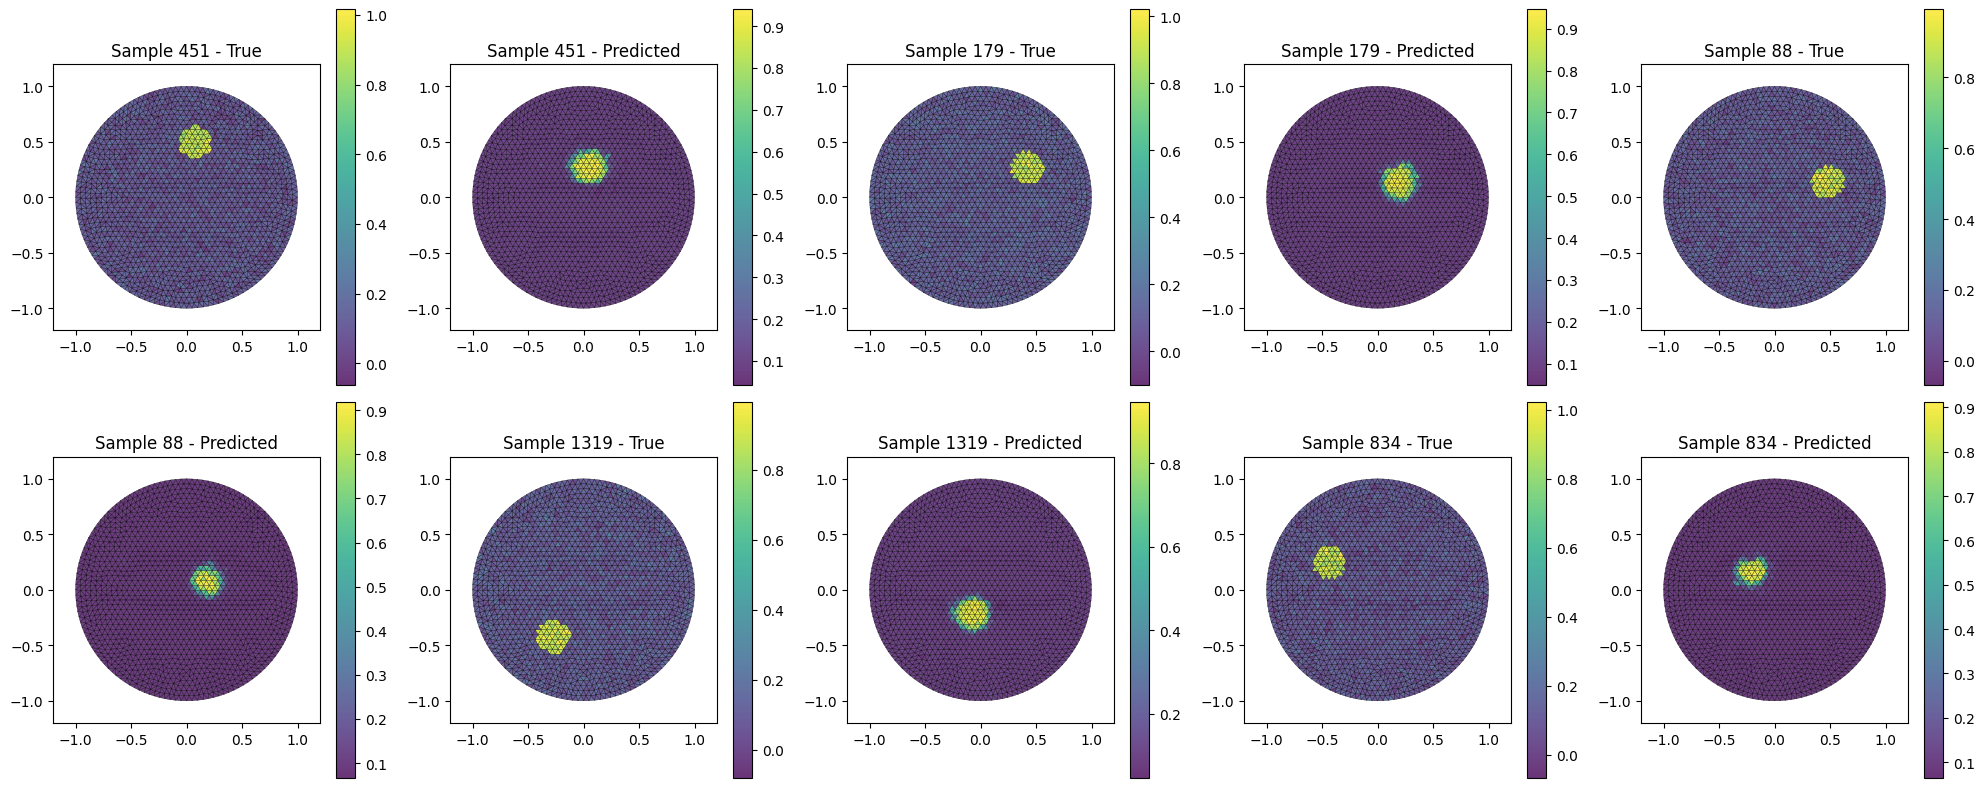

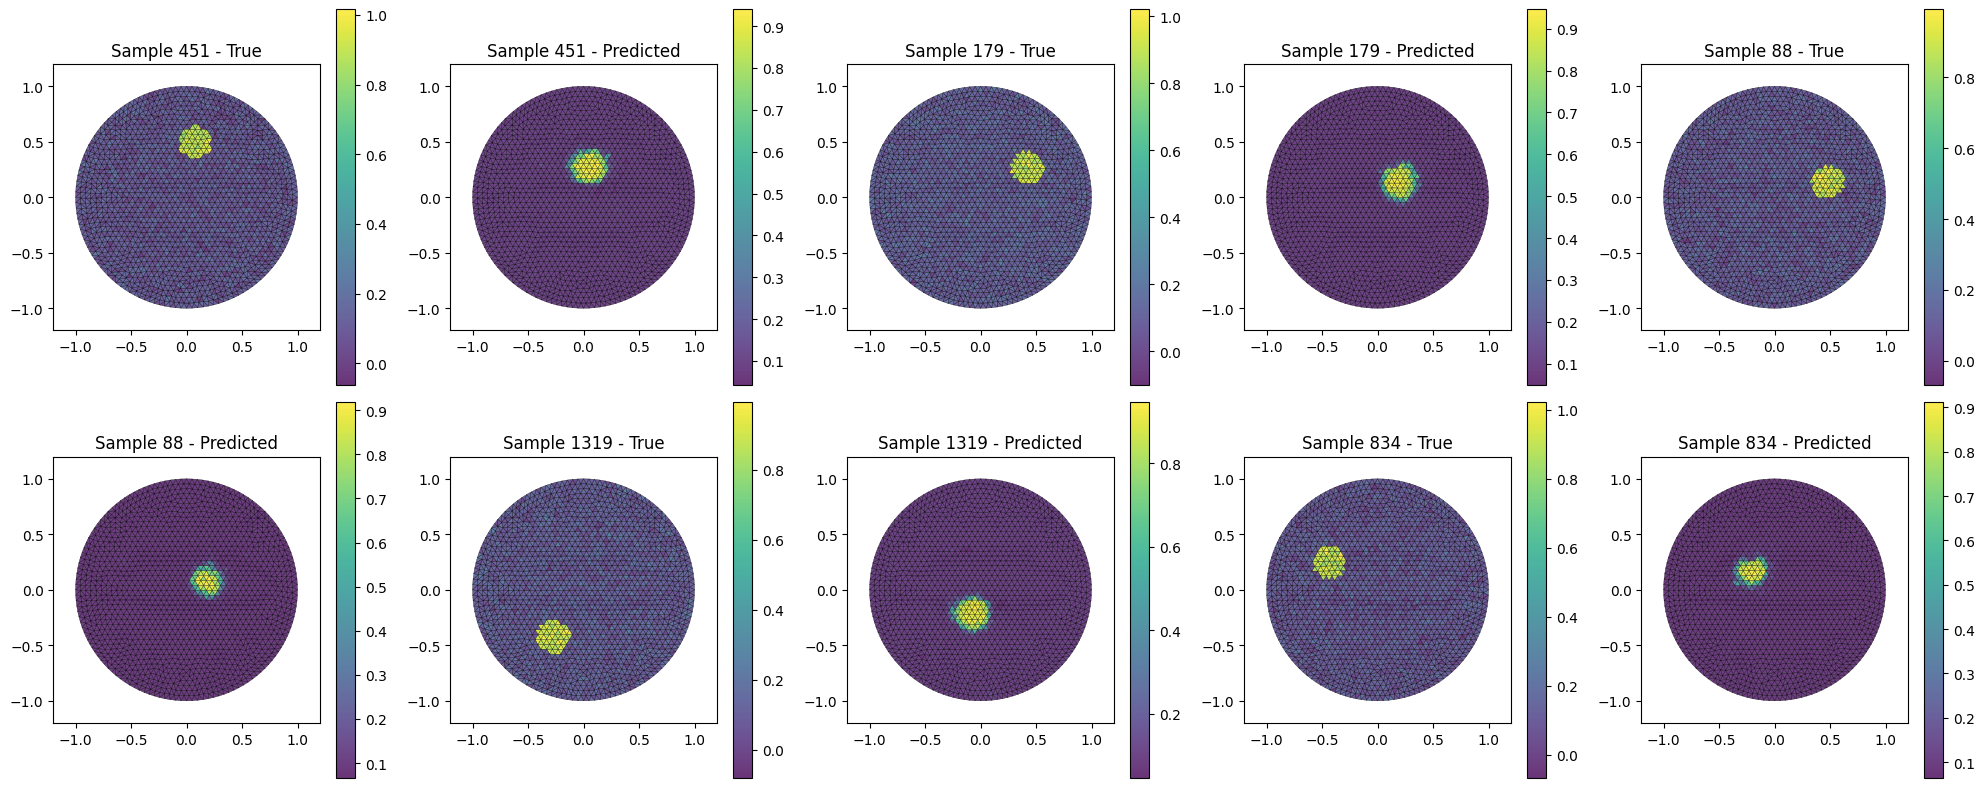

In [28]:
plot_random_recon_examples(mesh_obj, gamma_true_test, gamma_pred_test)

In [29]:
voltage_test_sim, gamma_test_sim , _ = load_sim_data("data43")
voltage_test_normalized = (voltage_test_sim - np.mean(voltage_test_sim, axis=0)) / np.std(voltage_test_sim, axis=0)
voltage_test = voltage_test_normalized.reshape(-1, 32, 32, 1)  
gamma_true_test = gamma_test_sim.reshape(-1, 2840, 1)

In [30]:
voltage_test_seq, _ = seq_data(voltage_test, gamma_true_test, n_seg=4)
voltage_test_seq.shape

(1996, 4, 32, 32, 1)

In [31]:
pred_latent = lstm_mapper.predict(voltage_test_seq)
gamma_pred_test = vae.decoder.predict(pred_latent).reshape(-1, 2840)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Plot saved to: Abbildungen/random_deviations.pdf


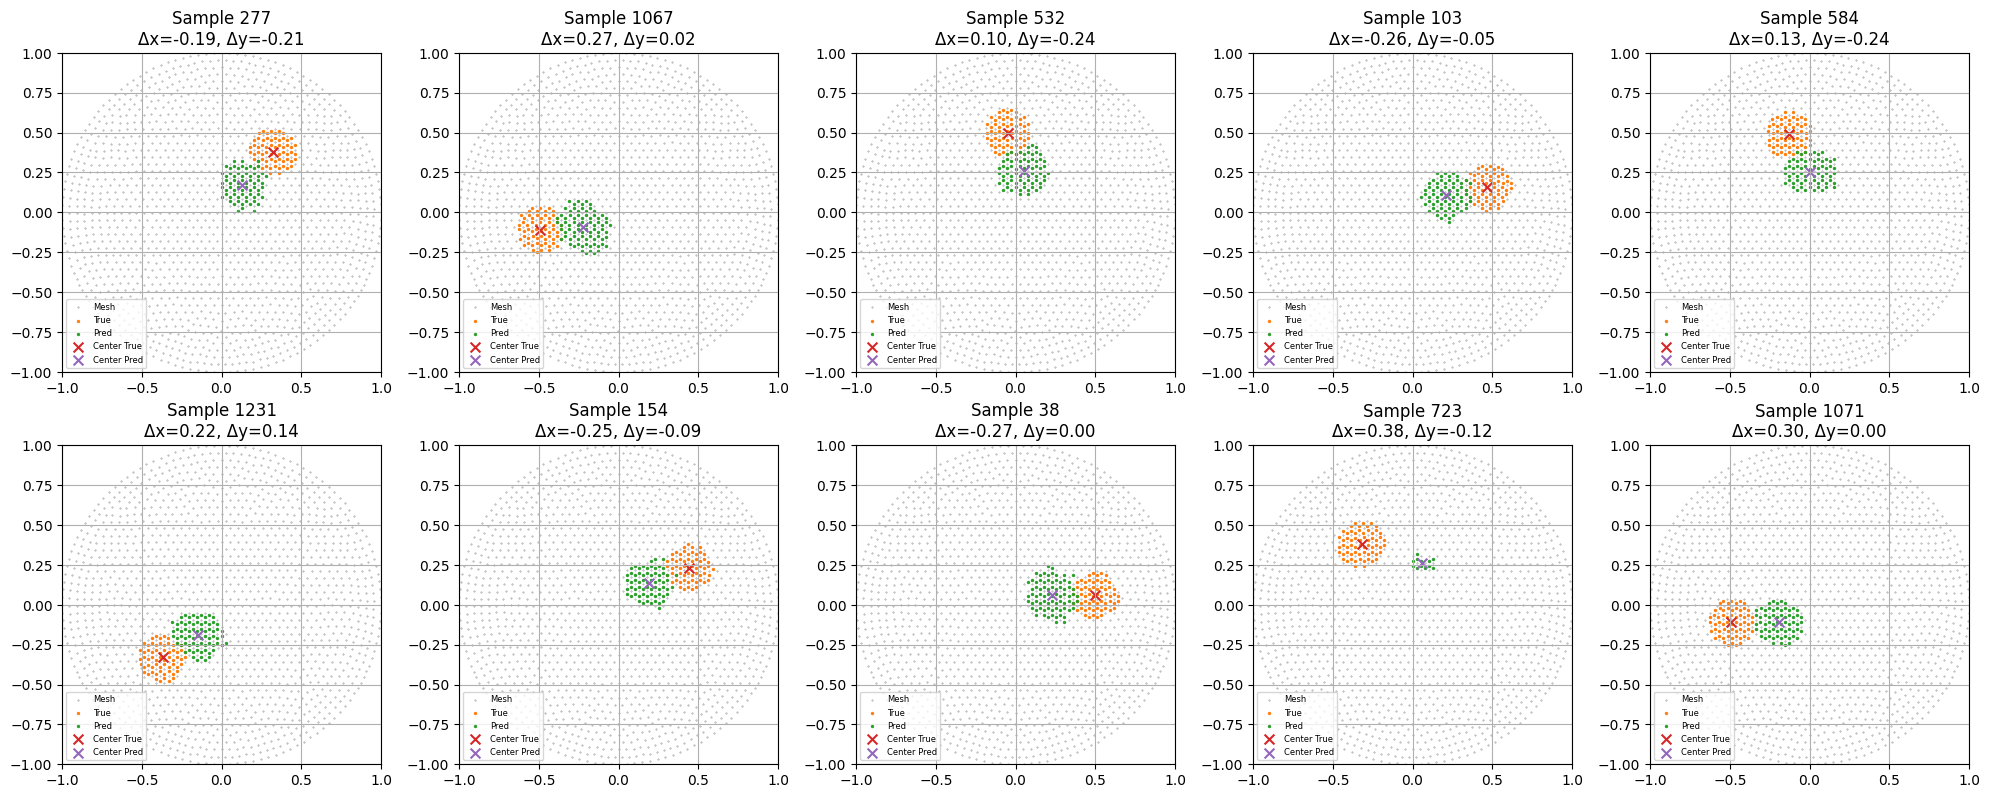

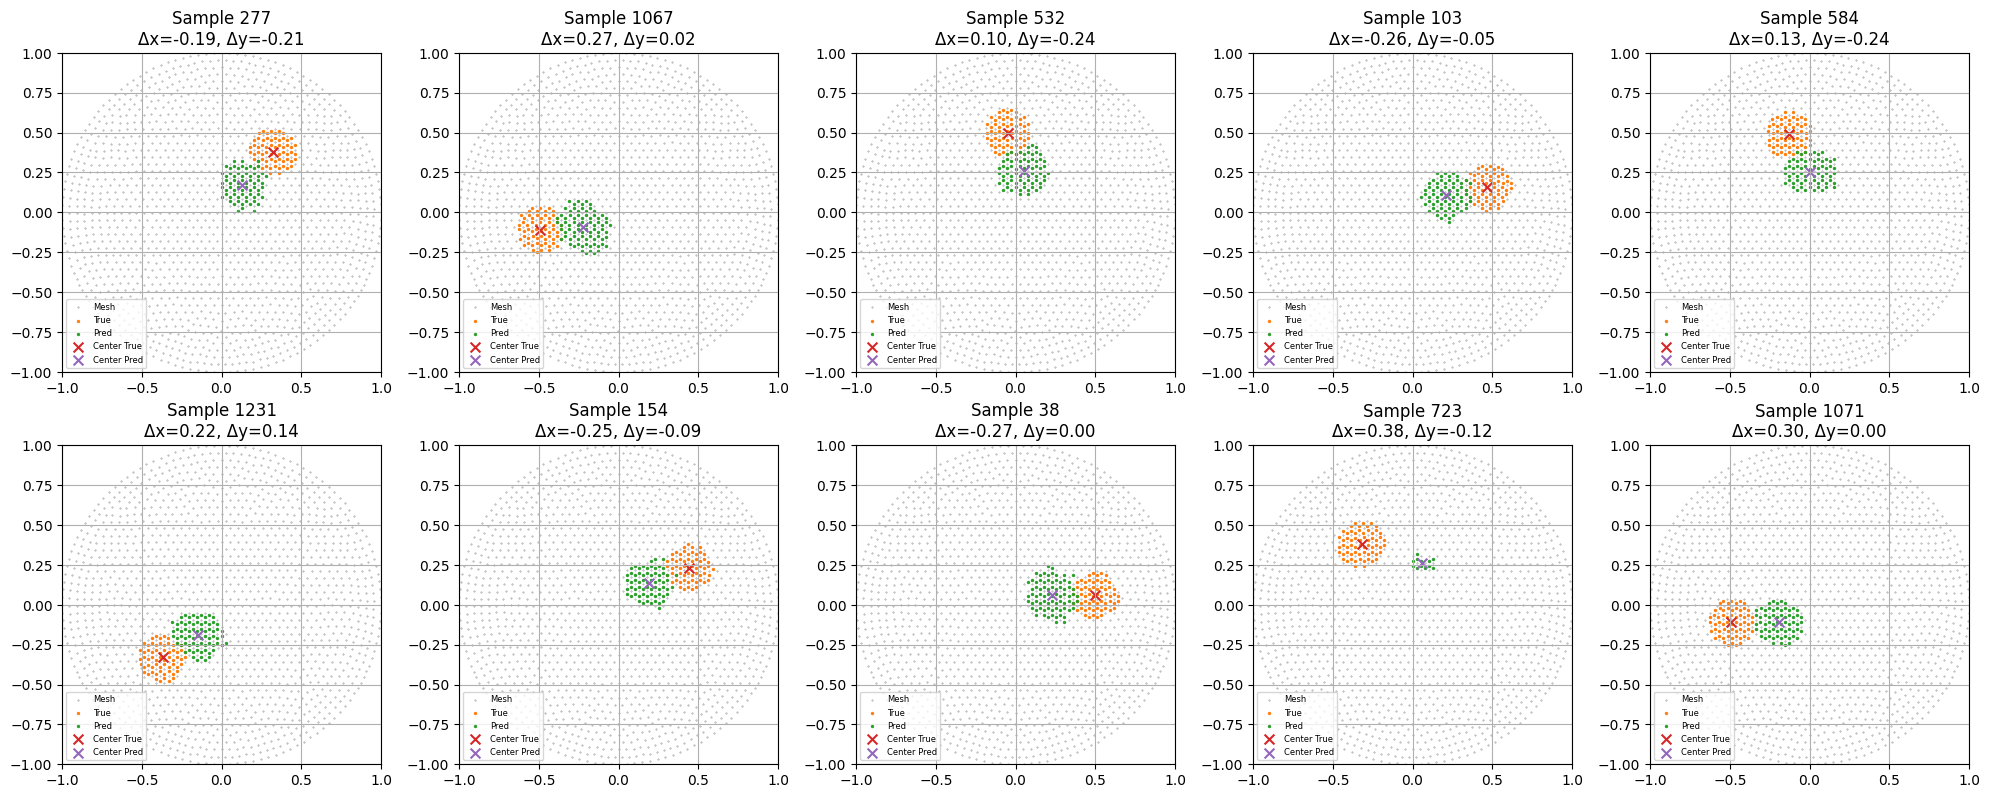

In [32]:
plot_random_deviations(mesh_obj, gamma_true_test, gamma_pred_test, 
                      num_samples=10, 
                      threshhold=0.5,
                      save=True,
                      fpath='Abbildungen/',
                      fname='random_deviations.pdf')

In [33]:
def evaluation_of_precision(gamma_true, gamma_pred, plot=True):
    """Calculates deviation of perm center and reconstructed perm space

    Returns:
    --------
    tuple or None
        Returns (delta_x, delta_y, delta_perm) if calculation successful,
        None if invalid data encountered
    """
    pts = mesh_obj.element
    tri = mesh_obj.node
    tri_centers = np.mean(tri[pts], axis=1)
    perm_min = 0.5 

    # Get indices and check if any were found
    indices1 = np.where(gamma_true > perm_min)[0]
    indices2 = np.where(gamma_pred > perm_min)[0]
    
    # Check if either array is empty
    if len(indices1) == 0 or len(indices2) == 0:
        if plot:
            print("Warning: No elements found above threshold in either true or predicted data")
        return None
    
    # Calculate coordinates and means
    coords1 = tri_centers[indices1]
    coords2 = tri_centers[indices2]
    
    # Calculate means with error checking
    x1 = np.mean(coords1[:, 0])
    y1 = np.mean(coords1[:, 1])
    x2 = np.mean(coords2[:, 0])
    y2 = np.mean(coords2[:, 1])
    
    # Check for NaN values
    if np.isnan([x1, y1, x2, y2]).any():
        if plot:
            print("Warning: NaN values encountered in coordinate calculations")
        return None
    
    x1 = round(x1, 3)
    y1 = round(y1, 3)
    x2 = round(x2, 3)
    y2 = round(y2, 3)

    delta_x = x1 - x2
    delta_y = y1 - y2
    delta_perm = len(coords1) - len(coords2)

    return delta_x, delta_y, delta_perm


def plot_deviations_x_y(Dict, save=False, fpath='', fname='x_y_deviation.pdf', figsize=(8, 8), limits=(-1, 1)):
    """Plot the x,y-deviation with enhanced styling
    
    Parameters
    ----------
    Dict : dictionary
        {'x-Abweichung': X, 'y-Abweichung': Y, 'Perm':Perm}
    save : Bool
        save plot
    fpath : string
        filepath
    fname : string
        name of the saved plot
    figsize : tuple
        figure size in inches
    limits : tuple
        x and y axis limits
    """

    # Data preparation
    df = pd.DataFrame({
        'x-Abweichung': np.asarray(Dict['x-Abweichung']).flatten(),
        'y-Abweichung': np.asarray(Dict['y-Abweichung']).flatten()
    })
        
    # Style settings
    plt.rcParams.update({'font.family': 'Serif'})
    sns.set(font_scale=1.5, font='Serif', style='whitegrid')
    # Create figure
    plt.figure(figsize=(7, 7))
    # Set plot limits
    plot_limits = [-1, 1]
    # Create joint plot
    g = sns.jointplot(
        data=df,
        x='x-Abweichung',
        y='y-Abweichung',
        kind='kde',
        xlim=limits,
        ylim=limits,
        height=figsize[0]
    )
        
    # Enhance the plot
    g.plot_joint(sns.kdeplot, fill=True, levels=50, cmap='viridis')
        
    # Add mean lines (keeping the red lines from your original)
    x_mean = np.mean(Dict['x-Abweichung'])
    y_mean = np.mean(Dict['y-Abweichung'])
    g.ax_joint.axvline(x=x_mean, color='r', linestyle='--', alpha=0.5)
    g.ax_joint.axhline(y=y_mean, color='r', linestyle='--', alpha=0.5)
        
    # Add statistics text box
    stats_text = (f"μx = {x_mean:.3f}\n"
                    f"μy = {y_mean:.3f}\n"
                    f"σx = {np.std(Dict['x-Abweichung']):.3f}\n"
                    f"σy = {np.std(Dict['y-Abweichung']):.3f}")
    g.ax_joint.text(0.02, 0.98, stats_text,
                       transform=g.ax_joint.transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    if save:
        plt.tight_layout()
        full_path = fpath + fname
        g.savefig(full_path)
        print(f"Plot saved to: {full_path}")  
    
    return g

def plot_deviations_perm(Dict, save=False, fpath='', fname='perm_deviation.pdf', binwidth=10):
    """Plot the x,y-deviation
    Parameters
    ----------
    Dict : dictionary
        {'x-Abweichung': X, 'y-Abweichung': Y, 'Perm':Perm}
    save : Bool
        save plot
    fpath : string
        filepath
    fname : string
        name of the saved plot
    binwidth : int
        seaborn binwidth plot configuration
    """
    plt.rcParams.update({'font.family': 'Serif'})
    df = pd.DataFrame.from_dict(Dict)
    plt.figure(figsize=(7, 7))
    plt.autoscale()
    sns.set(font_scale=2, font='Serif')
    
    # Create histogram plot
    p = sns.histplot(data=Dict['Perm'],
                    binwidth=10,
                    kde=True,
                    color='navy',
                    alpha=0.6)  
    
    # Calculate statistics
    mean_dev = np.mean(Dict['Perm'])
    std_dev = np.std(Dict['Perm'])
    st_fe = 2840
    percent_dev = (mean_dev/st_fe) * 100
    
    # Add vertical mean line
    p.axvline(x=mean_dev, color='red', linestyle=':', alpha=0.8)
    
    # Set labels
    p.set_xlabel("Abweichende Elemente")
    p.set_ylabel("Anzahl")
    fig = p.get_figure()
    
    if save:
        # Save plot
        plt.tight_layout()
        plt.savefig(fpath + fname)
        
        # Save statistics to text file
        stats_filename = fpath + 'perm_deviation_stats.txt'
        with open(stats_filename, 'w') as f:
            f.write(f'Mittlere Perm-Abweichung: {round(mean_dev)} [FE]\n')
            f.write(f'Standardabweichung: {round(std_dev, 1)} [FE]\n')
            f.write(f'Prozentuale Abweichung: {round(percent_dev, 2)} [%]\n')
        print(f"Statistics saved to: {stats_filename}")
    
    return fig

from PyPDF2 import PdfWriter, PdfReader

def merge_pdfs_horizontally(left_pdf, right_pdf, output_pdf):
    """
    Kombiniert zwei PDF-Seiten nebeneinander in eine neue PDF.
    
    Parameters
    ----------
    left_pdf : str
        Pfad zur linken PDF
    right_pdf : str
        Pfad zur rechten PDF
    output_pdf : str
        Pfad für die Ausgabe-PDF
    """
    # PDF Reader für beide Eingabe-PDFs
    reader_left = PdfReader(left_pdf)
    reader_right = PdfReader(right_pdf)
    
    # Neue PDF erstellen
    writer = PdfWriter()
    
    # Erste Seite von jeder PDF nehmen
    left_page = reader_left.pages[0]
    right_page = reader_right.pages[0]
    
    # Seiten zum Writer hinzufügen
    writer.add_page(left_page)
    writer.add_page(right_page)
    
    # Als neue PDF speichern
    with open(output_pdf, 'wb') as output_file:
        writer.write(output_file)
    
    print(f"Merged PDF saved as: {output_pdf}")




Plot saved to: Abbildungen/position_sim_few_unbalanced_interpol_reconstruct_deviations.pdf
Statistics saved to: Abbildungen/perm_deviation_stats.txt
Merged PDF saved as: Abbildungen/combined_sim_few_unbalanced_deviations.pdf


<Figure size 700x700 with 0 Axes>

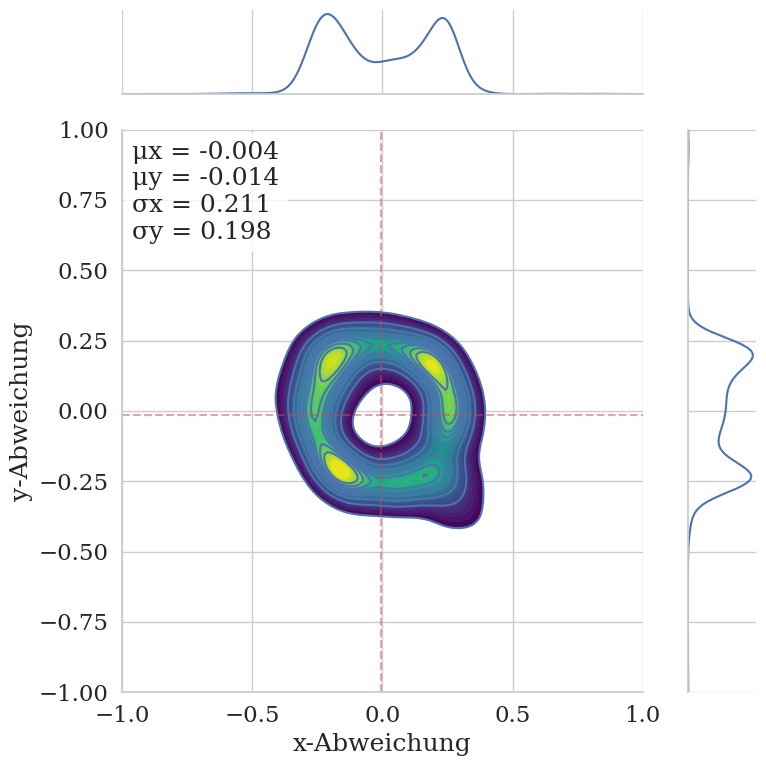

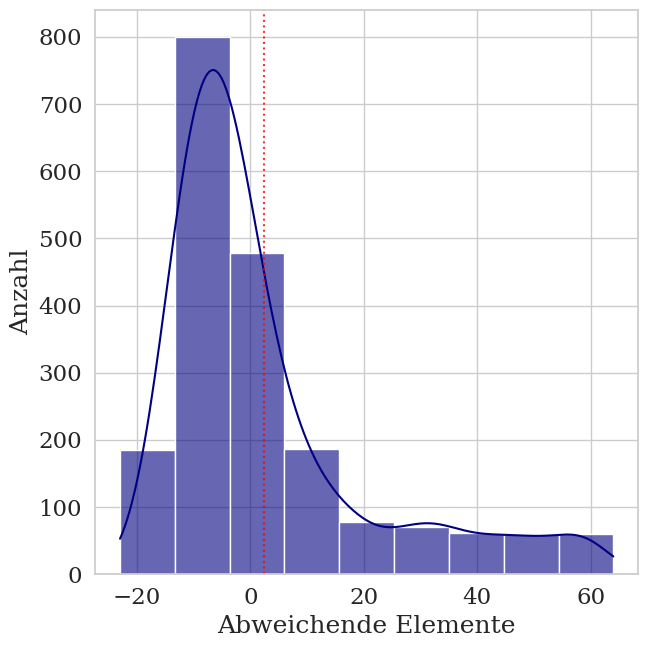

In [35]:
deviations_dict = {'x-Abweichung': [], 'y-Abweichung': []}
perm_dict = {'Perm': []}
for gt, pred in zip(gamma_true_test, gamma_pred_test):
    result = evaluation_of_precision(gt, pred, plot=False)
    if result is not None:  # Nur gültige Ergebnisse verwenden
        delta_x, delta_y, delta_perm = result
        deviations_dict['x-Abweichung'].append(delta_x)
        deviations_dict['y-Abweichung'].append(delta_y)
        perm_dict['Perm'].append(delta_perm)
# Für Position-Deviationen
g = plot_deviations_x_y(deviations_dict, 
                       save=True,
                       fpath='Abbildungen/',
                       fname='position_sim_few_unbalanced_interpol_reconstruct_deviations.pdf')
# Für Permittivitäts-Deviationen
fig = plot_deviations_perm(perm_dict,
                          save=True,
                          fpath='Abbildungen/',
                          fname='perm_sim_few_unbalanced_interpol_reconstruct_deviations.pdf',
                          binwidth=15)

merge_pdfs_horizontally(
     'Abbildungen/position_sim_few_unbalanced_interpol_reconstruct_deviations.pdf',
     'Abbildungen/perm_sim_few_unbalanced_interpol_reconstruct_deviations.pdf',
     'Abbildungen/combined_sim_few_unbalanced_deviations.pdf'
 )

In [ ]:
#FE - Finite Elemente (Elemente)

In [ ]:
# Einmalige Definition von Pfad und Basisnamen
fpath = 'Abbildungen/'
base_fname = 'sim_few_unbalanced_interpol_reconstruct'

# Führe komplette Analyse aus
run_deviation_analysis(gamma_true, gamma_pred_test, mesh_obj, fpath, base_fname)